# Example Code for using meshpy

In [1]:
from meshpy import triangle, geometry
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.meshers import *
from src.environment import *
from src.dynamics import *
from tqdm import tqdm

## Building Geometry

In [2]:
builder = geometry.GeometryBuilder()

Add Circle

In [3]:
points,facets,_,facet_markers = geometry.make_circle(.5,(0.0,0.0),marker = 1)
builder.add_geometry(points,facets,facet_markers=facet_markers)

Add Box

In [4]:
points,facets,_,_ = geometry.make_box((-1.0, -1.0), (1.0, 1.0),subdivisions=(100, 100))
builder.add_geometry(points,facets, facet_markers=1)

## Setting Mesh Info

In [6]:
info = triangle.MeshInfo()
builder.set(info)
info.set_holes([(0.0, 0.0)]) # Sets center circle as a hole

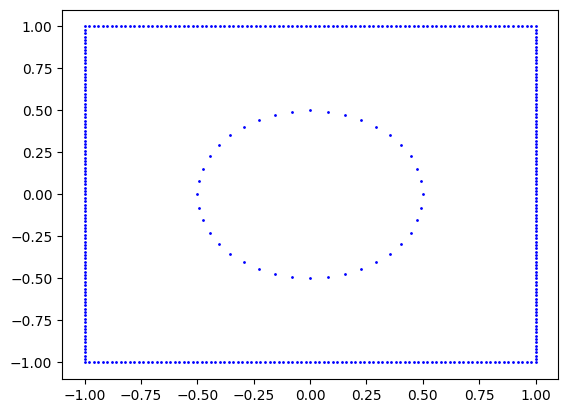

In [7]:
points = np.array(info.points)
plt.scatter(points[...,0], points[...,1], s=1, c='blue', label='Mesh Points')
plt.show()

Meshing

In [8]:
mesh = triangle.build(info,min_angle=30.0,max_volume=.001,generate_faces=True,generate_neighbor_lists=True,attributes=True)

## Plotting

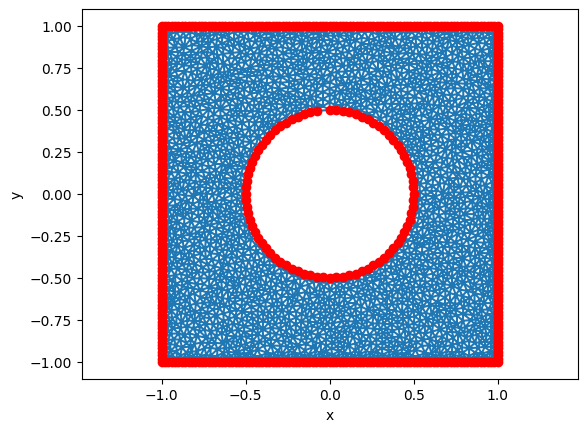

In [14]:
mesh_points = np.array(mesh.points)
mesh_tris = np.array(mesh.elements)
mesh_attr = np.array(mesh.point_markers)

import matplotlib.pyplot as plt

plt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris)
plt.xlabel("x")
plt.ylabel("y")
#
n = np.size(mesh_attr)
inner_nodes = [i for i in range(n) if mesh_attr[i] == 1]
outer_nodes = [i for i in range(n) if mesh_attr[i] == 3]
plt.plot(mesh_points[inner_nodes, 0], mesh_points[inner_nodes, 1], "ro")
plt.plot(mesh_points[outer_nodes, 0], mesh_points[outer_nodes, 1], "go")
plt.axis("equal")
plt.show()

In [15]:
import sys
sys.path.append('..')
from src.meshers import *
from src.environment import *
from src.dynamics import *
mesher = Mesher()
mesher.import_meshpy(mesh)

In [ ]:
mesher.calc_mesh_properties()

In [12]:
dynamics = D2Q9(tau = .05,delta_t=.1)
cells,faces,nodes = mesher.to_env(dynamics)
env = Environment(cells,faces,nodes)
env.init()

In [13]:
env = env.step()